In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neolen-house-price-prediction/sample_submission.csv
/kaggle/input/neolen-house-price-prediction/data_description.txt
/kaggle/input/neolen-house-price-prediction/train.csv
/kaggle/input/neolen-house-price-prediction/test.csv
/kaggle/input/neolen-house-price-prediction/house-prices-advanced-regression-techniques.zip


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/neolen-house-price-prediction/train.csv")
test_df = pd.read_csv("/kaggle/input/neolen-house-price-prediction/test.csv")

# Drop the Id column
train_df.drop("Id", axis=1, inplace=True)

In [4]:
# Summary statistics to get overview sight of the dataset
print("Summary Statistics:")
'''
Generates summary statistics for each column of the DataFrame train_df:
- count: The number of non-null (non-NaN) entries in the column.
- mean: The average value of the column (only relevant for numeric data).
- std: The standard deviation, which measures the amount of variation or dispersion in the column.
- min: The smallest value in the column.
- 25%: The 25th percentile, also known as the first quartile. This indicates that 25% of the data falls below this value.
- 50% (median): The median value, where half of the data falls below this value.
- 75%: The 75th percentile, or third quartile, indicating that 75% of the data falls below this value.
- max: The largest value in the column.
'''
print(train_df.describe(include='all'))


Summary Statistics:
         MSSubClass MSZoning  LotFrontage        LotArea Street Alley  \
count   1259.000000     1259  1041.000000    1259.000000   1259    76   
unique          NaN        5          NaN            NaN      2     2   
top             NaN       RL          NaN            NaN   Pave  Grvl   
freq            NaN      995          NaN            NaN   1253    42   
mean      56.914218      NaN    70.110471   10524.300238    NaN   NaN   
std       42.353617      NaN    23.522213   10391.598333    NaN   NaN   
min       20.000000      NaN    21.000000    1300.000000    NaN   NaN   
25%       20.000000      NaN    59.000000    7590.000000    NaN   NaN   
50%       50.000000      NaN    70.000000    9452.000000    NaN   NaN   
75%       70.000000      NaN    80.000000   11611.000000    NaN   NaN   
max      190.000000      NaN   313.000000  215245.000000    NaN   NaN   

       LotShape LandContour Utilities LotConfig  ...     PoolArea PoolQC  \
count      1259        1259

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


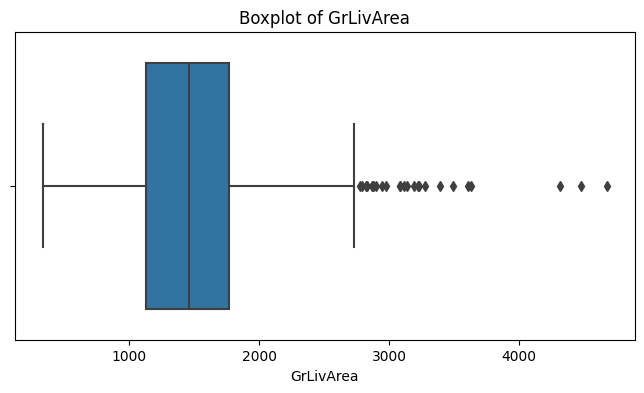

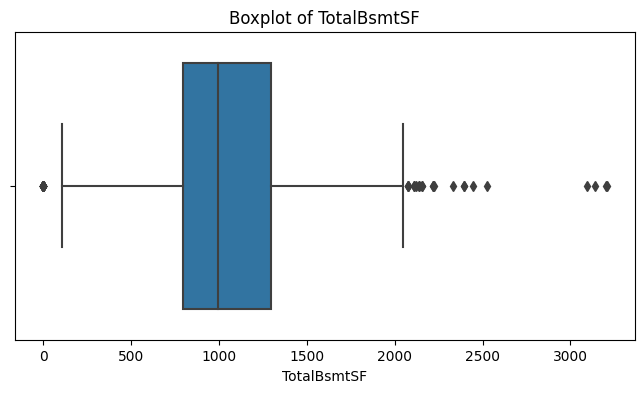

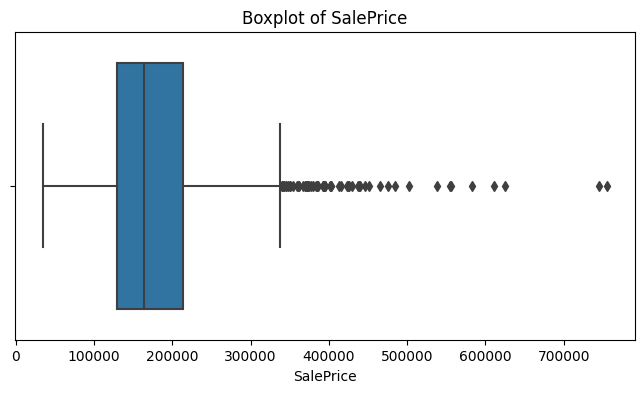

Removed 128 outlier rows. New shape: (1131, 80)


In [5]:
# Visualize outliers in key features
def plot_outliers(df, feature):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()

for col in ["GrLivArea", "TotalBsmtSF", "SalePrice"]:
    if col in train_df.columns:
        plot_outliers(train_df, col)

# Remove outliers using IQR method for selected features
def remove_outliers(df, features):
    for feature in features:
        if feature in df.columns:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df = df[(df[feature] >= lower) & (df[feature] <= upper)]
    return df

# Store original shape for comparison
original_shape = train_df.shape
train_df = remove_outliers(train_df, ["GrLivArea", "TotalBsmtSF", "SalePrice"])
print(f"Removed {original_shape[0] - train_df.shape[0]} outlier rows. New shape: {train_df.shape}")

# Outlier Detection and Removal
Outliers can negatively impact model performance. We'll visualize and remove outliers from key numerical features using the IQR method.

In [6]:
# Filtering out missing values columns and suming missing cells
missing_values = train_df.isnull().sum()
# Sorting missing columns by missing rows
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nMissing Values:")
print(missing_values)


Missing Values:
PoolQC          1129
MiscFeature     1083
Alley           1057
Fence            902
MasVnrType       696
FireplaceQu      568
LotFrontage      209
GarageType        62
GarageYrBlt       62
GarageFinish      62
GarageQual        62
GarageCond        62
MasVnrArea         5
BsmtExposure       1
dtype: int64


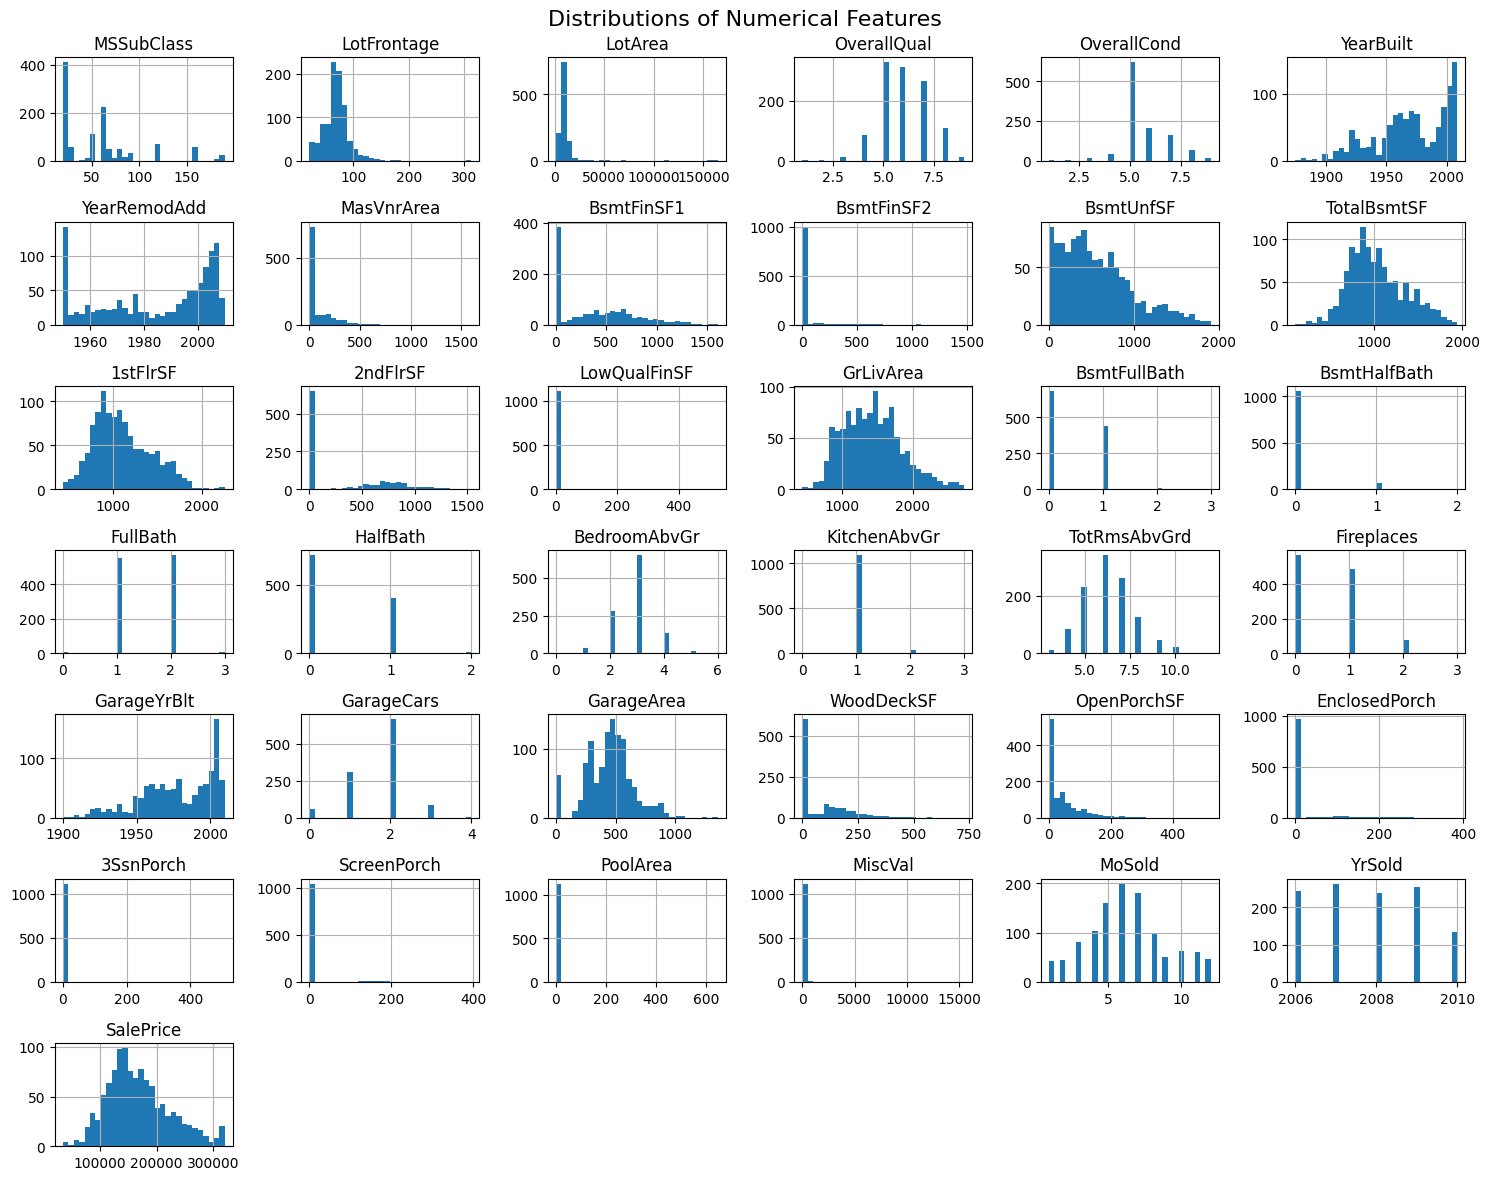

In [7]:
# Visualize distributions of numerical features

## Filter out numeric type columns
numerical_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
## Creates histograms for each of the numerical columns selected from train_df
## - Set width of 15 inches and a height of 12 inches are specified,
## - Indicates that the data should be divided into 30 equally spaced bins
train_df[numerical_cols].hist(figsize=(15, 12), bins=30)
plt.suptitle("Distributions of Numerical Features", fontsize=16)
## Adjust layout to prevent overlap
plt.tight_layout()
## Display the histograms
plt.show()


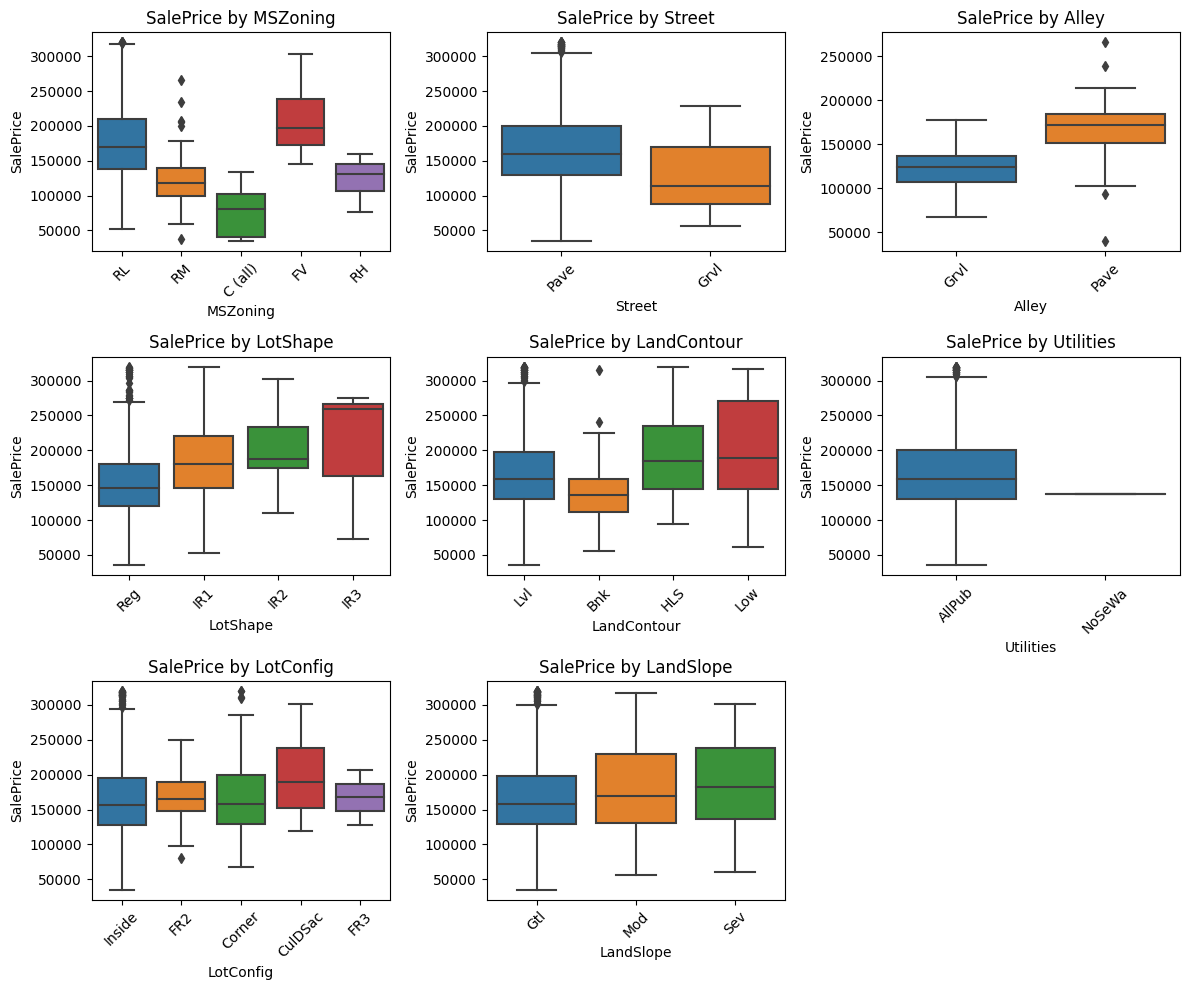

In [8]:
# Visualize categorical features and their relationship with SalePrice
categorical_cols = train_df.select_dtypes(include=["object"]).columns
plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_cols[:8]):  # Show top 4 for brevity
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=col, y="SalePrice", data=train_df)
    plt.xticks(rotation=45)
    plt.title(f"SalePrice by {col}")
plt.tight_layout()
plt.show()

# Exploratory Data Analysis: Categorical Features
Let's visualize the distribution of some important categorical features and their relationship with SalePrice.

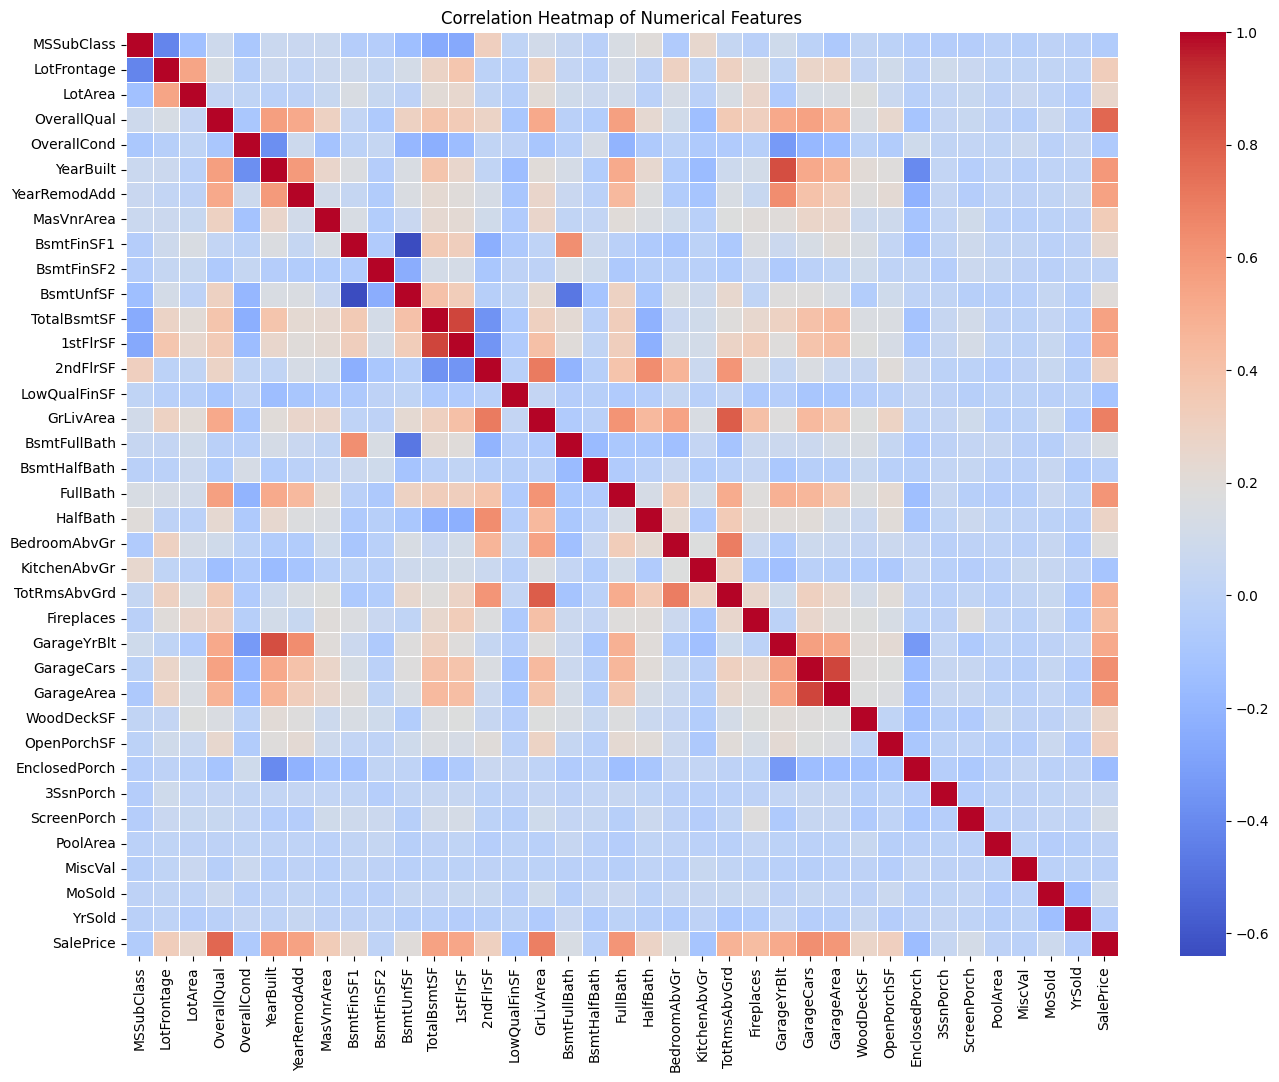

Correlation of features with SalePrice:

SalePrice        1.000000
OverallQual      0.769489
GrLivArea        0.691417
GarageCars       0.633459
FullBath         0.603473
GarageArea       0.598924
YearBuilt        0.590060
YearRemodAdd     0.554509
TotalBsmtSF      0.552616
1stFlrSF         0.537375
GarageYrBlt      0.516554
TotRmsAbvGrd     0.480019
Fireplaces       0.427792
MasVnrArea       0.336440
LotFrontage      0.326853
OpenPorchSF      0.312268
2ndFlrSF         0.301755
HalfBath         0.278092
WoodDeckSF       0.263890
LotArea          0.253508
BsmtFinSF1       0.238916
BsmtUnfSF        0.198103
BedroomAbvGr     0.192152
BsmtFullBath     0.143381
ScreenPorch      0.121444
MoSold           0.081562
3SsnPorch        0.050402
BsmtFinSF2       0.011503
PoolArea         0.006402
MiscVal         -0.011811
BsmtHalfBath    -0.021883
YrSold          -0.044291
MSSubClass      -0.053532
OverallCond     -0.070079
LowQualFinSF    -0.102542
KitchenAbvGr    -0.108350
EnclosedPorch   -0.1556

In [9]:
# Compute the correlation matrix
# This matrix shows pairwise correlation between numerical features
correlation_matrix = train_df[numerical_cols].corr()

# Plot the correlation heatmap
# This visualizes the correlation matrix using a color-coded heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Print correlation values with SalePrice
# This helps identify which features are most strongly related to the target variable
saleprice_correlation = correlation_matrix["SalePrice"].sort_values(ascending=False)
print("Correlation of features with SalePrice:\n")
print(saleprice_correlation)


In [10]:
# Drop the Id column
test_ids = test_df["Id"]
test_df.drop("Id", axis=1, inplace=True)

# Separate features and target
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]

In [11]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

print("numerical_cols\n", numerical_cols)
print("categorical_cols\n", categorical_cols)

numerical_cols
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
categorical_cols
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    

# Log Transformation of SalePrice
The SalePrice variable is often right-skewed. Applying a log transformation can help normalize the distribution and improve model performance.

In [12]:
# Handle missing values
numerical_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")


# Encoding categorical variables
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Feature scaling
scaler = StandardScaler()

# Create preprocessing pipelines
numerical_pipeline = Pipeline([
    ("imputer", numerical_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline([
    ("imputer", categorical_imputer),
    ("encoder", categorical_encoder)
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

In [13]:
# Feature selection
feature_selector = SelectKBest(score_func=f_regression, k=50)

# Create full pipeline
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", feature_selector),
    ("regressor", LinearRegression())
])

# Fit the model
model_pipeline.fit(X, y)

# Predict on test data
predictions = model_pipeline.predict(test_df)

# Save predictions to CSV
output_df = pd.DataFrame({"Id": test_ids, "SalePrice": predictions})
output_df.to_csv("house_price_predictions.csv", index=False)
